# NLP for News Article Classification and Analysis 
##### This project employs NLP techniques to classify news articles into relevant categories. It utilizes TF-IDF for text vectorization, and by employing various classifiers such as Random Forest, KNN, SVM, and Logistic Regression, the project conducts comparisons to identify the best-performing model. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pickle
import re

In [2]:
# Read the data
data = pd.read_csv("/Users/saikodze/Desktop/news-article-categories.csv")
data.head(3)

,category,title,body
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis..."
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...


In [15]:
data.shape

(6872, 3)

In [3]:
# Drop null values
data.isnull().sum()
data.dropna(inplace=True)

In [4]:
# Extracting unique categories
categories = data.groupby("category")["category"].count()
labels = categories.index
labels

Index(['ARTS & CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'MEDIA', 'POLITICS', 'RELIGION',
       'SCIENCE', 'SPORTS', 'TECH', 'WOMEN'],
      dtype='object', name='category')

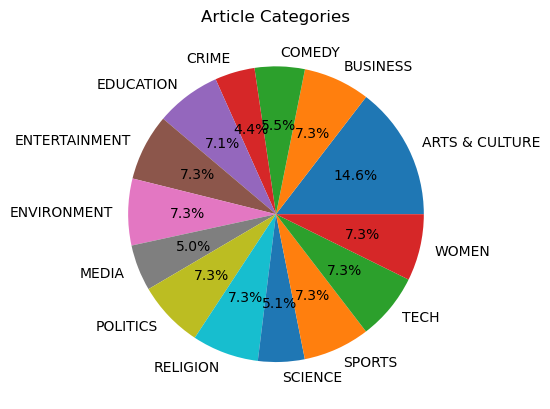

In [5]:
# Plot the distribution of article categories

plt.title("Article Categories")
plt.pie(categories, labels=labels, autopct='%1.1f%%')
plt.show()

In [6]:
# Define a function to clean the text data using regular expressions

def clean_text(text):
    def regex_clean(txt):
        txt = re.sub(r'\xa0', '', txt).strip("[()/”’‘“.,]")
        txt = re.sub(r'\.+', ' ', txt)
        txt = re.sub(r'―', '', txt)
        return txt

    return " ".join([regex_clean(x) for x in text.split(" ")])



# Apply the clean_text function to the 'body' column
data["body"] = data["body"].apply(lambda text: clean_text(text))


In [7]:
# Initialize TF-IDF Vectorizer 
tvf = TfidfVectorizer(stop_words='english')

# Vectorize the text data
vectorized_text = tvf.fit_transform(data["body"])

In [8]:
# Encode the category labels 
le = LabelEncoder()
encoded_labels = le.fit_transform(data['category'])

# Create mapping dictionary
category_mapping = {pair[0]: pair[1] for pair in zip(set(encoded_labels), data['category'].unique())}
data['category'] = encoded_labels

In [9]:

# Split the data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(vectorized_text, data['category'], test_size=0.2, random_state=42)


In [10]:
classifiers = [RandomForestClassifier, KNeighborsClassifier, SVC, LogisticRegression]
y_pred = None

In [11]:
""""
Select the best-performing model among the given list of classifier models.

""""
def select_best_model(models):
    
    global y_pred
    best_score = 0
    
    for model in models:
        # Train the classifier
        clf = OneVsRestClassifier(model())
        clf.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = clf.predict(x_test)
        
        # Calculate accuracy score
        acc_score = accuracy_score(y_test, y_pred)
        print(f"Accuracy score for {str(model.__name__)}: ", acc_score)

        # Check if the current model has achieved a better score than the previous best model
        if acc_score > best_score:
            with open("model.pickle", "wb") as pickle_file:
                pickle.dump(clf, pickle_file)
            best_score = acc_score


select_best_model(classifiers)

Accuracy score for RandomForestClassifier:  0.8050909090909091


In [26]:
"""
Scores:
    Accuracy score for RandomForestClassifier:  0.8050909090909091
    Accuracy score for KNeighborsClassifier:  0.6661818181818182
    Accuracy score for SVC:  0.8008
    Accuracy score for RandomForestClassifier:  0.7956363636363636
    Accuracy score for LogisticRegression:  0.7883636363636364
    
    
Reasoning:    
    The current classification scores may be challenging to improve due to the presence of 
    overlapping categories within each label. In many cases, an article may belong to multiple 
    categories simultaneously, making it inherently difficult to classify them accurately into a single category.

"""

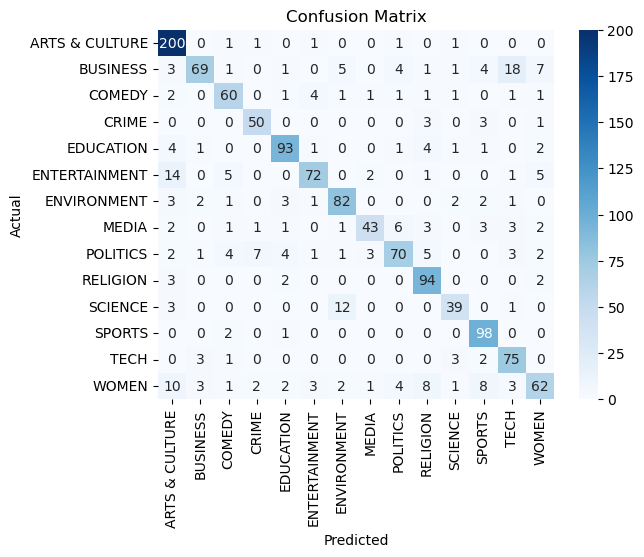

In [12]:
# Create confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



## Predictiong appropriate category for the article

In [13]:
def find_appropriate_category(text):
    
    global tvf
    
    # Clean the text
    text = clean_text(text)
    
    # Transform the cleaned text
    transformed_text = tvf.transform([text])
    
    # Load the trained model
    with open("model.pickle", "rb") as pickle_file:
        model = pickle.load(pickle_file)

    # Make a prediction
    prediction = model.predict(transformed_text)[0]
    
     # Map the numerical prediction
    prediction = category_mapping.get(prediction, 'unknown')
    print(f"Predicted category: {prediction}")
    
    return prediction

In [24]:
# EXAMPLE TEST

input_text = ("SAN FRANCISCO June 21 Reuters - Instagram now boasts more than 500 million users more than" 
              "80 percent of whom are outside the United States the company said on Tuesday in a sign of "
              "the photo-sharing app\'s rapidly growing global reach The company owned by Facebook Inc had 400"
              "million users last September It has seen its user base more than double over the past two years "
              "Instagram added that 300 million people used the app every day Instagram has quickly eclipsed its" 
              "rivals notably Twitter Inc which has seen its user base stall at just above 300 million Facebook has" 
              "about 1 6 billion users Facebook bought Instagram in 2012 for $1 billion its first large acquisition")

find_appropriate_category(text = input_text)

Predicted category: TECH


'TECH'